In [21]:
import os
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from utils.utils import *

# Create DataFrame For Dataset & DataLoader

In [282]:
df = get_dataframe_undersampling('data/train')

In [12]:
# df.to_csv('train_undersampling.csv', index=False)

# Load DataFrame and Create Dataset & DataLoader

In [288]:
class XRayDataset(Dataset):
    def __init__(self, data, transform=None): ## add max_sentence
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data.iloc[idx, 0])
        image = Image.open(img_path).resize((256, 256))
        image = image.convert('L')
        image = np.array(image)
        
        if self.transform != None:
            image = self.transform(image)
        
        label = self.data.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [289]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_val = pd.read_csv('data/val.csv')

In [313]:
# transform = T.Compose([
#     T.Resize(256),
#     T.ToTensor(),
# ])
transform = MorphTransform(5)

train_dataset = XRayDataset(df_train, transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
for i, (x, y) in enumerate(train_dataloader):
    if i < 2:
        print(x.shape)

# Morphological Improvement

In [324]:
img = Image.open(df_train.iloc[0, 0]).resize((256, 256))
img = img.convert('L')
img = np.array(img)

kernel_size = 5
kernel = np.ones((kernel_size, kernel_size),np.uint8)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
top = cv2.subtract(img, opening)

closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
bot = cv2.subtract(closing, img)

img_enh = cv2.subtract(cv2.add(img, top), bot)

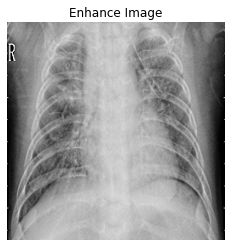

In [328]:
plt.title("Enhance Image")
plt.axis(False)
plt.imshow(img_enh, cmap='gray')
plt.show()

In [329]:
class MorphTransform:
    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def __call__(self, img):
        kernel = np.ones((self.kernel_size, self.kernel_size),np.uint8)
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        top = cv2.subtract(img, opening)

        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        bot = cv2.subtract(closing, img)

        img_enh = cv2.subtract(cv2.add(img, top), bot)
        img_enh = np.expand_dims(img_enh, axis=0)
        return torch.from_numpy(img_enh)

In [240]:
t = MorphTransform(5)
img_enh = t(img)

# Historgram Equalization Improvement

## Remove Diaphragm

In [267]:
img = Image.open(df.iloc[0, 0]).resize((256, 256))
img = img.convert('L')
img = np.array(img)

vmax = img.max()
vmin = img.min()
threshold = vmin + 0.9 * (vmax - vmin)

_, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

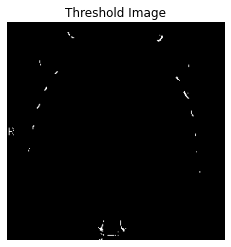

In [268]:
plt.title("Threshold Image")
plt.axis(False)
plt.imshow(thres, cmap='gray')
plt.show()

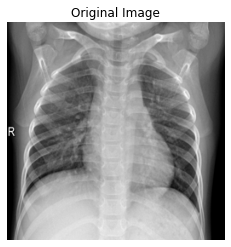

In [269]:
plt.title("Original Image")
plt.axis(False)
plt.imshow(img, cmap='gray')
plt.show()

## Improve with equalization and bilateral filter

In [270]:
equalized = cv2.equalizeHist(img)

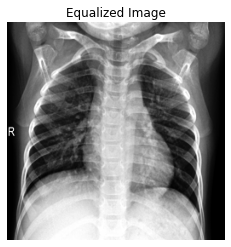

In [271]:
plt.title("Equalized Image")
plt.axis(False)
plt.imshow(equalized, cmap='gray')
plt.show()

In [272]:
bilateral = cv2.bilateralFilter(img, 9, 75, 75)

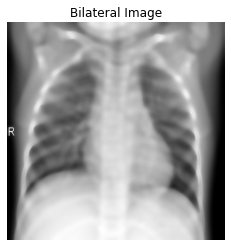

In [273]:
plt.title("Bilateral Image")
plt.axis(False)
plt.imshow(bilateral, cmap='gray')
plt.show()

In [274]:
R = np.expand_dims(equalized, axis=2)
G = np.expand_dims(img, axis=2)
B = np.expand_dims(bilateral, axis=2)

img_rgb = np.concatenate([R, G, B], axis=2)

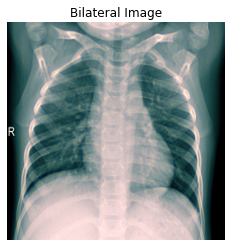

In [275]:
plt.title("Bilateral Image")
plt.axis(False)
plt.imshow(img_rgb)
plt.show()

In [301]:
class CADTransform:
    def __init__(self, r=9, var=75, axis=0):
        self.r = r
        self.var = var
        self.axis = axis

    def __call__(self, img):
        equalized = cv2.equalizeHist(img)
        bilateral = cv2.bilateralFilter(img, self.r, self.var, self.var)
        R = np.expand_dims(equalized, axis=self.axis)
        G = np.expand_dims(img, axis=self.axis)
        B = np.expand_dims(bilateral, axis=self.axis)

        img_rgb = np.concatenate([R, G, B], axis=self.axis)
        
        return torch.from_numpy(img_rgb)

In [278]:
t = CADTransform()
img_enh = t(img)

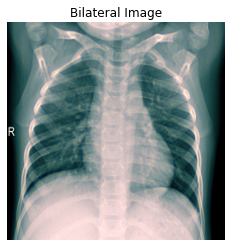

In [279]:
plt.title("Bilateral Image")
plt.axis(False)
plt.imshow(img_enh)
plt.show()